In [2]:
from qutip import *
import numpy as np
import scipy as sp
import math
import matplotlib.pyplot as plt
from scipy.special import genlaguerre as L

In [3]:
def psi(g,e):
    return np.array([g, e])

def pulse(t, Omega0, delta, phi0, phi1):
    Omega = np.sqrt(Omega0**2 + delta**2)
    
    if Omega == 0.0:
        U = np.array([[1.0 , 0.0],
                      [0.0 , 1.0]])
        
    else:
        U = np.array([[np.cos(Omega*t/2.0) -(1.0j*delta/Omega)*np.sin(Omega*t/2.0), (1.0j*Omega0/Omega)*np.sin(Omega*t/2.0)],
                     [(1.0j*Omega0/Omega)*np.sin(Omega*t/2.0) , np.cos(Omega*t/2.0) + (1.0j*delta/Omega)*np.sin(Omega*t/2.0)]])
    
    V1 = np.array([[1.0 , 0.0],
                   [0.0 , np.exp(-1.0j*phi1)]])
    
    V0 = np.array([[1.0 , 0.0],
                   [0.0 , np.exp(1.0j*phi0)]])
    
    return np.exp(1.0j*delta*t/2.0)*V1@U@V0

def thermPulse(psi0, t, Omega0, delPrime, phi0, phi1, eta, nbar, Ncut): #1-dimensional
    result = psi(0.0+0.0j,0.0+0.0j)
    for n in range(Ncut):
        result += prob(n,nbar)*pulse(t, Omega0*Omega(n,0,eta), delPrime, phi0, phi1)@psi0
    return result

def therm3DPulse(psi0, t, Omega0, delPrime, nbars, Omegas, Ncut):
    nbarx = nbars[0]
    nbary = nbars[1]
    nbarz = nbars[2]
    #Ncut = 100
    result = psi(0.0+0.0j,0.0+0.0j)
    for nx in range(Ncut):
        Probx = prob(nx,nbarx)
        for ny in range(Ncut):
            Probxy = Probx*prob(ny,nbary)
            for nz in range(Ncut):
                result += Probxy*prob(nz,nbarz)*pulse(t, Omega0*Omegas[nx,ny,nz], delPrime, 0.0, 0.0)@psi0
    return result

def rhoee(psi):
    return (abs(psi[1]))**2.0

def rhogg(psi):
    return (abs(psi[0]))**2.0

def prob(n,nbar):
    return 1.0/(nbar+1)*(nbar/(nbar+1))**n    #returns prob of being in state n given nbar

def Omega(n,m,eta):
    return np.exp(-eta**2/2.0) * eta**(np.abs(m)) * (math.factorial(n)/math.factorial(n+m))**(np.sign(m)/2.0) \
        * L(n,np.abs(m))(eta**2)              #returns unitless rabi rate of transition n -> n+m given Lamb-Dicke Parameter

In [4]:
def HRerrSig(psi0, t1, T, t2, delta, delPrime, Omega01, Omega02):
    pulse1 = pulse(t1, Omega01, delPrime, 0.0, 0.0)
    pulse2 = pulse(t2, Omega02, delPrime, 0.0, 0.0)
    freeEvo = pulse(T, 0.0, delta, 0.0, 0.0)
    pi2PhaseInjP = pulse(0.0, 0.0, 0.0, 0.0, np.pi/2.0)
    pi2PhaseInjM = pulse(0.0, 0.0, 0.0, 0.0, -np.pi/2.0)
    
    return rhoee(pulse2@freeEvo@pi2PhaseInjP@pulse1@psi0) - rhoee(pulse2@freeEvo@pi2PhaseInjM@pulse1@psi0)

In [5]:
def HRJump(deld, psi0, t, T, Delta, Omega0):
    delPrime = deld - Delta
    pulse1 = pulse(t, Omega0, delPrime, 0.0, 0.0)
    pulse2 = pulse(2.0*t, Omega0, delPrime, -np.pi, np.pi)
    pulse3 = pulse(t, Omega0, delPrime, 0.0, 0.0)
    freeEvo = pulse(T, 0.0, deld, 0.0, 0.0)
    return pulse3@pulse2@freeEvo@pulse1@psi0

def HRJumpTest(deld, psi0, t, T, Delta, Omega0):
    delPrime = deld - Delta
    pulse1 = pulse(t, Omega0, delPrime, 0.0, 0.0)
    pulse2 = pulse(2.0*t, -Omega0, delPrime, 0.0, 0.0)
    pulse3 = pulse(t, Omega0, delPrime, 0.0, 0.0)
    freeEvo = pulse(T, 0.0, deld, 0.0, 0.0)
    return pulse3@pulse2@freeEvo@pulse1@psi0

In [6]:
def HRAp(deld, psi0, t, T, Delta, Omega0):
    delPrime = deld - Delta
    pulse1 = pulse(t, Omega0, delPrime, np.pi/2.0, -np.pi/2.0)
    freeEvo = pulse(T, 0.0, deld, 0.0, 0.0)
    pulse2 = pulse(2.0*t, Omega0, delPrime, np.pi, -np.pi)
    pulse3 = pulse(t, Omega0, delPrime, 0.0, 0.0)
    return pulse3@pulse2@freeEvo@pulse1@psi0

def HRAn(deld, psi0, t, T, Delta, Omega0):
    delPrime = deld - Delta
    pulse1 = pulse(t, Omega0, delPrime, -np.pi/2.0, np.pi/2.0)
    freeEvo = pulse(T, 0.0, deld, 0.0, 0.0)
    pulse2 = pulse(2.0*t, Omega0, delPrime, np.pi, -np.pi)
    pulse3 = pulse(t, Omega0, delPrime, 0.0, 0.0)
    return pulse3@pulse2@freeEvo@pulse1@psi0

def HRBp(deld, psi0, t, T, Delta, Omega0):
    delPrime = deld - Delta
    pulse1 = pulse(t, Omega0, delPrime, 0.0, 0.0)
    freeEvo = pulse(T, 0.0, deld, 0.0, 0.0)
    pulse2 = pulse(2.0*t, Omega0, delPrime, np.pi, -np.pi/2.0)
    pulse3 = pulse(t, Omega0, delPrime, 0.0, -np.pi/2.0)
    return pulse3@pulse2@freeEvo@pulse1@psi0

def HRBn(deld, psi0, t, T, Delta, Omega0):
    delPrime = deld - Delta
    pulse1 = pulse(t, Omega0, delPrime, 0.0, 0.0)
    freeEvo = pulse(T, 0.0, deld, 0.0, 0.0)
    pulse2 = pulse(2.0*t, Omega0, delPrime, np.pi, -3.0*np.pi/2.0)
    pulse3 = pulse(t, Omega0, delPrime, 0.0, np.pi/2.0)
    return pulse3@pulse2@freeEvo@pulse1@psi0

In [7]:
def HRAThermp(deld, psi0, t, T, Delta, Omega0, eta, nbar0, nbarf, Ncut):
    #thermPulse(psi0, t, Omega0, delPrime, phi0, phi1, eta, nbar, Ncut):
    delPrime = deld - Delta
    freeEvo = pulse(T, 0.0, deld, 0.0, 0.0)
    state1 = thermPulse(psi0, t, Omega0, delPrime, np.pi/2.0, -np.pi/2.0, eta, nbar0, Ncut)
    state2 = freeEvo@state1
    state3 = thermPulse(state2, 2.0*t, Omega0, delPrime, np.pi, -np.pi, eta, nbarf, Ncut)
    state4 = thermPulse(state3, t, Omega0, delPrime, 0.0, 0.0, eta, nbarf, Ncut)
    return state4

def HRAThermn(deld, psi0, t, T, Delta, Omega0, eta, nbar0, nbarf, Ncut):
    delPrime = deld - Delta
    freeEvo = pulse(T, 0.0, deld, 0.0, 0.0)
    state1 = thermPulse(psi0, t, Omega0, delPrime, -np.pi/2.0, np.pi/2.0, eta, nbar0, Ncut)
    state2 = freeEvo@state1
    state3 = thermPulse(state2, 2.0*t, Omega0, delPrime, np.pi, -np.pi, eta, nbarf, Ncut)
    state4 = thermPulse(state3, t, Omega0, delPrime, 0.0, 0.0, eta, nbarf, Ncut)
    return state4
    
def HRBThermp(deld, psi0, t, T, Delta, Omega0, eta, nbar0, nbarf, Ncut):
    delPrime = deld - Delta
    freeEvo = pulse(T, 0.0, deld, 0.0, 0.0)
    state1 = thermPulse(psi0, t, Omega0, delPrime, 0.0, 0.0, eta, nbar0, Ncut)
    state2 = freeEvo@state1
    state3 = thermPulse(state2, 2.0*t, Omega0, delPrime, np.pi, -np.pi/2.0, eta, nbarf, Ncut)
    state4 = thermPulse(state3, t, Omega0, delPrime, 0.0, -np.pi/2.0, eta, nbarf, Ncut)
    return state4

def HRBThermn(deld, psi0, t, T, Delta, Omega0, eta, nbar0, nbarf, Ncut):
    delPrime = deld - Delta
    freeEvo = pulse(T, 0.0, deld, 0.0, 0.0)
    state1 = thermPulse(psi0, t, Omega0, delPrime, 0.0, 0.0, eta, nbar0, Ncut)
    state2 = freeEvo@state1
    state3 = thermPulse(state2, 2.0*t, Omega0, delPrime, np.pi, -3.0*np.pi/2.0, eta, nbarf, Ncut)
    state4 = thermPulse(state3, t, Omega0, delPrime, 0.0, np.pi/2.0, eta, nbarf, Ncut)
    return state4

In [8]:
def MHRErrSig1(deld, psi0, t, T, Delta, Omega0):
    return rhoee(HRAp(deld, psi0, t, T, Delta, Omega0)) - rhoee(HRBn(deld, psi0, t, T, Delta, Omega0))

def MHRErrSig2(deld, psi0, t, T, Delta, Omega0):
    return rhoee(HRBp(deld, psi0, t, T, Delta, Omega0)) - rhoee(HRAn(deld, psi0, t, T, Delta, Omega0))

In [9]:
def MHRThermES1(deld, psi0, t, T, Delta, Omega0, eta, nbar0, nbarf, Ncut):
    return rhoee(HRAThermp(deld, psi0, t, T, Delta, Omega0, eta, nbar0, nbarf, Ncut)) - rhoee(HRBThermn(deld, psi0, t, T, Delta, Omega0, eta, nbar0, nbarf, Ncut))

def MHRThermES2(deld, psi0, t, T, Delta, Omega0, eta, nbar0, nbarf, Ncut):
    return rhoee(HRBThermp(deld, psi0, t, T, Delta, Omega0, eta, nbar0, nbarf, Ncut)) - rhoee(HRAThermn(deld, psi0, t, T, Delta, Omega0, eta, nbar0, nbarf, Ncut))

In [10]:
pts = 50
psi0 = psi(1.0, 0.0)
delds = np.linspace(-18.0*(2.0*np.pi), 18.0*(2.0*np.pi), pts)
t = 10.0e-3
T = 5.0*t
Omega0 = np.pi/(2.0*t)
Delta = -14.0*(2.0*np.pi)
rho22ps = np.zeros(pts)
rho22ns = np.zeros(pts)
for ii in range(pts):
    rho22ps[ii] = rhoee(HRAp(-delds[ii], psi0, t, T, -Delta, Omega0))
    rho22ns[ii] = rhoee(HRBn(-delds[ii], psi0, t, T, -Delta, Omega0))

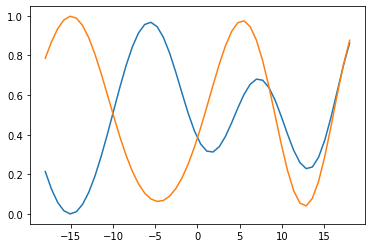

In [146]:
plt.plot(delds/(2.0*np.pi), rho22ps)
plt.plot(delds/(2.0*np.pi), rho22ns)

(-1.0, 1.0)

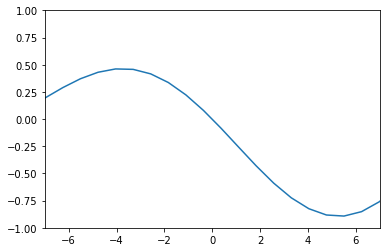

In [108]:
errsig = rho22ps - rho22ns
plt.plot(delds/(2.0*np.pi), errsig)
plt.xlim([-7.0, 7.0])
plt.ylim([-1,1])

In [154]:
pts = 500
psi0 = psi(1.0, 0.0)
delds = np.linspace(-110.0*(2.0*np.pi), 110.0*(2.0*np.pi), pts)
t = 10.0e-3
T = 4.0*t
Omega0 = np.pi/(2.0*t)
Delta = 0.0
rho22pts = np.zeros(pts)

for ii in range(pts):
    rho22pts[ii] = rhoee(HRAp(-delds[ii], psi0, t, T, -Delta, Omega0))

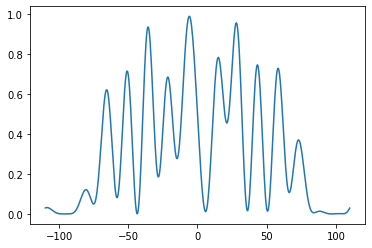

In [155]:
plt.plot(delds/(2.0*np.pi), rho22pts)


In [152]:
pts = 500
psi0 = psi(1.0, 0.0)
delds = np.linspace(-110.0*(2.0*np.pi), 110.0*(2.0*np.pi), pts)
t = 10.0e-3
T = 4.0*t
Omega0 = np.pi/(2.0*t)
Delta = 0.0
rho22pt2s = np.zeros(pts)

for ii in range(pts):
    rho22pt2s[ii] = rhoee(HRBn(-delds[ii], psi0, t, T, -Delta, Omega0))

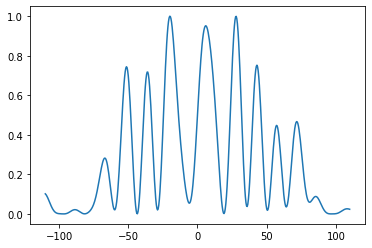

In [153]:
plt.plot(delds/(2.0*np.pi), rho22pt2s)


In [18]:
pts = 500
psi0 = psi(1.0, 0.0)
delds = np.linspace(-110.0*(2.0*np.pi), 110.0*(2.0*np.pi), pts)
t = 10.0e-3
T = 4.0*t
Omega0 = np.pi/(2.0*t)
Delta = 0.0
rho22pts = np.zeros(pts)
testpts = np.zeros(pts)
nbar0 = 10.0
nbarf = 15.0
Ncut = 200
eta = 0.05

for ii in range(pts):
    rho22pts[ii] = rhoee(HRAp(-delds[ii], psi0, t, T, -Delta, Omega0))
    testpts[ii] = rhoee(HRAThermp(-delds[ii], psi0, t, T, -Delta, Omega0, eta, nbar0, nbarf, Ncut))
    

D:\Mark\Python\lib\site-packages\scipy\special\_orthogonal.py:651: RuntimeWarning: invalid value encountered in double_scalars
  hn = _gam(n + alpha + 1) / _gam(n + 1)
D:\Mark\Python\lib\site-packages\scipy\special\_orthogonal.py:140: RuntimeWarning: invalid value encountered in multiply
  np.poly1d.__init__(self, poly.coeffs * float(kn))
D:\Mark\Python\lib\site-packages\scipy\special\_orthogonal.py:196: RuntimeWarning: overflow encountered in true_divide
  w = 1.0 / (fm * dy)
D:\Mark\Python\lib\site-packages\scipy\special\_orthogonal.py:202: RuntimeWarning: invalid value encountered in multiply
  w *= mu0 / w.sum()
D:\Mark\Python\lib\site-packages\scipy\special\_orthogonal.py:127: RuntimeWarning: invalid value encountered in double_scalars
  equiv_weights = [weights[k] / wfunc(roots[k]) for
D:\Mark\Python\lib\site-packages\scipy\special\_orthogonal.py:196: RuntimeWarning: divide by zero encountered in true_divide
  w = 1.0 / (fm * dy)


KeyboardInterrupt: 

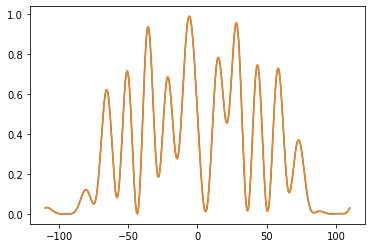

In [17]:
plt.plot(delds/(2.0*np.pi), rho22pts)
plt.plot(delds/(2.0*np.pi), testpts)

In [18]:
Ncut = 201
psi0 = psi(0.0, 1.0)
Delta = 1.0 #*(2.0*np.pi)  #hz
Omega0 = 157.0 #*(2.0*np.pi) #hz
nbarf = 15.0 #n/sec
nbar0 = 10.0
t = 10.0e-3
T = 50.0e-3
eta = 0.05

tol = 1.0e-10
x0 = -0.01
x1 = 0.05

pts = 25
delds = np.linspace(-20.0, 20.0, pts)
errSigPts1 = np.zeros(pts,)

for ii in range(pts):
    print(ii)
    #HRJumpThermErrSig(deld, psi0, t1, T, t2, Delta, Omega0, eta, nbar0, nbardot, Ncut):
    errSigPts1[ii] =MHRThermES1(delds[ii], psi0, t, T, Delta, Omega0, eta, nbar0, nbarf, Ncut)

0


D:\Mark\Python\lib\site-packages\scipy\special\_orthogonal.py:651: RuntimeWarning: invalid value encountered in double_scalars
  hn = _gam(n + alpha + 1) / _gam(n + 1)
D:\Mark\Python\lib\site-packages\scipy\special\_orthogonal.py:140: RuntimeWarning: invalid value encountered in multiply
  np.poly1d.__init__(self, poly.coeffs * float(kn))
D:\Mark\Python\lib\site-packages\scipy\special\_orthogonal.py:196: RuntimeWarning: overflow encountered in true_divide
  w = 1.0 / (fm * dy)
D:\Mark\Python\lib\site-packages\scipy\special\_orthogonal.py:202: RuntimeWarning: invalid value encountered in multiply
  w *= mu0 / w.sum()
D:\Mark\Python\lib\site-packages\scipy\special\_orthogonal.py:127: RuntimeWarning: invalid value encountered in double_scalars
  equiv_weights = [weights[k] / wfunc(roots[k]) for
D:\Mark\Python\lib\site-packages\scipy\special\_orthogonal.py:196: RuntimeWarning: divide by zero encountered in true_divide
  w = 1.0 / (fm * dy)


1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24


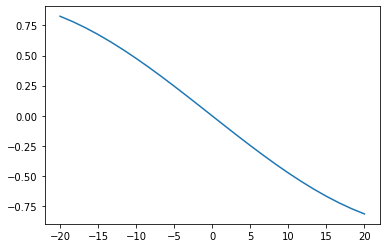

In [19]:
plt.plot(delds,errSigPts1, label = "err")

In [21]:
pts = 15
Ncut = 201
psi0 = psi(0.0, 1.0)
Delta = 1.0 #*(2.0*np.pi) #hz
Omega0 = 157.0 #*(2.0*np.pi) #hz
nbar0 = 10.0 
t = 10.0e-3
T = 50.0e-3
eta = 0.05
nbarfs = np.linspace(10, 300, pts)
shifts1 = np.zeros(pts)
shifts2 = np.zeros(pts)

tol = 1.0e-11
x0 = -0.1
x1 = 0.5
guessTol = 5.0
for ii in range(pts):
    print(ii)
    #print(nbarfs[ii])
    shifts1[ii] = sp.optimize.root_scalar(MHRThermES1, args=(psi0, t, T, Delta, Omega0, eta, nbar0, nbarfs[ii], Ncut), bracket=[x0,x1], xtol = tol).root
    #print(shifts1[ii])
    x0 = shifts1[ii] - guessTol
    x1 = shifts1[ii] + guessTol
    #print(x0,x1)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14


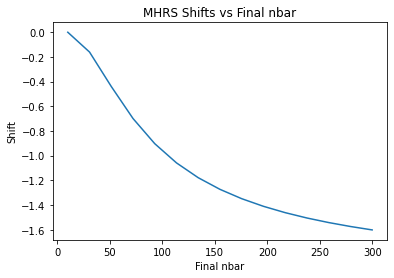

In [28]:
plt.plot(nbarfs, shifts1)
plt.xlabel("Final nbar")
plt.ylabel("Shift")
plt.title("MHRS Shifts vs Final nbar")
plt.show()

In [27]:
shifts1[0]

-2.7051742918653563e-14

In [29]:
for ii in range(pts):
    print(ii)
    #print(nbarfs[ii])
    shifts2[ii] = sp.optimize.root_scalar(MHRThermES2, args=(psi0, t, T, Delta, Omega0, eta, nbar0, nbarfs[ii], Ncut), bracket=[x0,x1], xtol = tol).root
    #print(shifts1[ii])
    x0 = shifts1[ii] - guessTol
    x1 = shifts1[ii] + guessTol
    #print(x0,x1)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14


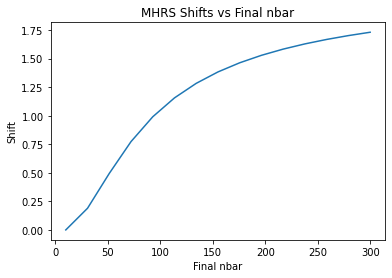

In [30]:
plt.plot(nbarfs, shifts2)
plt.xlabel("Final nbar")
plt.ylabel("Shift")
plt.title("MHRS Shifts vs Final nbar")
plt.show()

In [31]:
shifts2[0]

-1.4123227557868422e-14

Ncut convergence test:

In [12]:
pts = 15
Ncuts = np.array([201, 401, 601])
psi0 = psi(0.0, 1.0)
Delta = 1.0 #*(2.0*np.pi) #hz
Omega0 = 157.0 #*(2.0*np.pi) #hz
nbar0 = 10.0 
t = 10.0e-3
T = 50.0e-3
eta = 0.05
nbarfs = np.linspace(10, 150, pts)
shifts1 = np.zeros([np.size(Ncuts),pts])
shifts2 = np.zeros(pts)

tol = 1.0e-11
x0 = -0.1
x1 = 0.5
guessTol = 5.0
for ii in range(np.size(Ncuts)):
    print(Ncuts[ii])
    x0 = -0.1
    x1 = 0.5
    for jj in range(pts):
        print(nbarfs[jj])
        shifts1[ii][jj] = sp.optimize.root_scalar(MHRThermES1, args=(psi0, t, T, Delta, Omega0, eta, nbar0, nbarfs[jj], Ncuts[ii]), bracket=[x0,x1], xtol = tol).root
        x0 = shifts1[ii][jj] - guessTol
        x1 = shifts1[ii][jj] + guessTol
        #print(x0,x1)

201
10.0


D:\Mark\Python\lib\site-packages\scipy\special\_orthogonal.py:651: RuntimeWarning: invalid value encountered in double_scalars
  hn = _gam(n + alpha + 1) / _gam(n + 1)
D:\Mark\Python\lib\site-packages\scipy\special\_orthogonal.py:140: RuntimeWarning: invalid value encountered in multiply
  np.poly1d.__init__(self, poly.coeffs * float(kn))
D:\Mark\Python\lib\site-packages\scipy\special\_orthogonal.py:196: RuntimeWarning: overflow encountered in true_divide
  w = 1.0 / (fm * dy)
D:\Mark\Python\lib\site-packages\scipy\special\_orthogonal.py:202: RuntimeWarning: invalid value encountered in multiply
  w *= mu0 / w.sum()
D:\Mark\Python\lib\site-packages\scipy\special\_orthogonal.py:127: RuntimeWarning: invalid value encountered in double_scalars
  equiv_weights = [weights[k] / wfunc(roots[k]) for
D:\Mark\Python\lib\site-packages\scipy\special\_orthogonal.py:196: RuntimeWarning: divide by zero encountered in true_divide
  w = 1.0 / (fm * dy)


20.0
30.0
40.0
50.0
60.0
70.0
80.0
90.0
100.0
110.0
120.0
130.0
140.0
150.0
401
10.0


D:\Mark\Python\lib\site-packages\scipy\special\_orthogonal.py:553: RuntimeWarning: overflow encountered in multiply
  - (n + alpha)*cephes.eval_genlaguerre(n-1, alpha, x))/x
D:\Mark\Python\lib\site-packages\scipy\special\_orthogonal.py:195: RuntimeWarning: invalid value encountered in true_divide
  dy /= np.abs(dy).max()


20.0
30.0
40.0
50.0
60.0
70.0
80.0
90.0
100.0
110.0
120.0
130.0
140.0
150.0
601
10.0
20.0
30.0
40.0
50.0
60.0
70.0
80.0
90.0
100.0
110.0
120.0
130.0
140.0
150.0


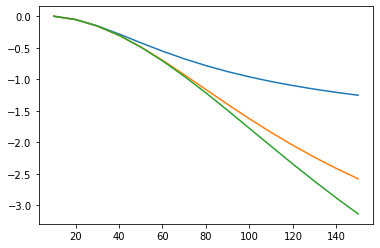

In [13]:
plt.plot(nbarfs,shifts1[0,:], label="Ncut=201")
plt.plot(nbarfs,shifts1[1,:], label="Ncut=401")
plt.plot(nbarfs,shifts1[2,:], label='Ncut=601')

In [14]:
pts = 15
Ncuts = np.array([701, 801, 901])
psi0 = psi(0.0, 1.0)
Delta = 1.0 #*(2.0*np.pi) #hz
Omega0 = 157.0 #*(2.0*np.pi) #hz
nbar0 = 10.0 
t = 10.0e-3
T = 50.0e-3
eta = 0.05
nbarfs = np.linspace(10, 150, pts)
shifts2 = np.zeros([np.size(Ncuts),pts])

tol = 1.0e-11
x0 = -0.1
x1 = 0.5
guessTol = 5.0
for ii in range(np.size(Ncuts)):
    print(Ncuts[ii])
    x0 = -0.1
    x1 = 0.5
    for jj in range(pts):
        print(nbarfs[jj])
        shifts2[ii][jj] = sp.optimize.root_scalar(MHRThermES1, args=(psi0, t, T, Delta, Omega0, eta, nbar0, nbarfs[jj], Ncuts[ii]), bracket=[x0,x1], xtol = tol).root
        x0 = shifts1[ii][jj] - guessTol
        x1 = shifts1[ii][jj] + guessTol
        #print(x0,x1)

701
10.0
20.0
30.0
40.0
50.0
60.0
70.0
80.0
90.0
100.0
110.0
120.0
130.0
140.0
150.0
801
10.0
20.0
30.0
40.0
50.0
60.0
70.0
80.0
90.0
100.0
110.0
120.0
130.0
140.0
150.0
901
10.0
20.0
30.0
40.0
50.0
60.0
70.0
80.0
90.0
100.0
110.0
120.0
130.0
140.0
150.0


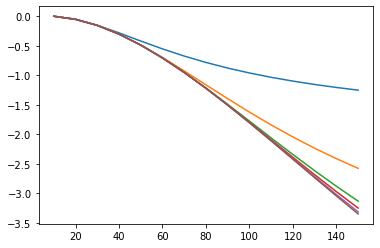

In [15]:
plt.plot(nbarfs,shifts1[0,:], label="Ncut=201")
plt.plot(nbarfs,shifts1[1,:], label="Ncut=401")
plt.plot(nbarfs,shifts1[2,:], label='Ncut=601')
plt.plot(nbarfs,shifts2[0,:], label="Ncut=701")
plt.plot(nbarfs,shifts2[1,:], label="Ncut=801")
plt.plot(nbarfs,shifts2[2,:], label='Ncut=901')